# house price pridiction

In [492]:
import os
import numpy as np
import pandas as pd
from scipy import stats


def OLS(X, Y):
    X_T = np.transpose(X)
    Betas = np.dot(np.dot(np.matrix(np.dot(X_T, X)).I, X_T), Y)
    Betas = np.array(Betas)
    return Betas


def Predict(X, Betas):
    Y_predict = np.dot(X, Betas)
    return Y_predict


def T_test(Betas, X, Y, Y_pre, N, col_names):
    Betas_interval = []
    beta_num = Betas.shape[0]
    U = Y - Y_pre
    S_sq = np.dot(U.transpose(), U)[0][0] / (N-K-1)
    SKK = np.matrix(np.dot(X.transpose(), X)).I
    for j in range(beta_num):
        Skk = SKK[j, j]
        Beta_i = Betas[j, 0]
        t_value = Beta_i/(Skk*S_sq)**0.5
        std = (Skk*S_sq)**0.5
        low = Beta_i-1.97*std
        up = Beta_i+1.97*std
        if Beta_i>low and Beta_i<up:
            IN_interval = 1
        else:
            IN_interval = 0
        PR = 2*(1- stats.t.cdf(abs(t_value), N-beta_num))
        ls_tmp = [Beta_i, t_value, PR, low, up, IN_interval]
        Betas_interval.append(ls_tmp)
        
    # transform into dataframe
    numpy_data = np.array(Betas_interval)
    df2 = pd.DataFrame(data=numpy_data, index=col_names, 
        columns=["beta", "t-value", "Pr(>|t|)", "low_bound", 'up_boud', 'in'])
    return numpy_data, df2
    

def R_suqare(Y_predict, Y):
    Y_mean = np.mean(Y)
    RSS = np.sum((Y_predict-Y)**2)
    TSS = np.sum((Y-Y_mean)**2)
    return 1- RSS/TSS


def Ftest(Betas, Y_predict, Y, K, N):
    ESS = np.sum((Y_predict-Y)**2)
    RSS = np.sum((Y_predict-np.mean(Y))**2)
    F = RSS/K/(ESS/(N-K-1))
    P_v = 2*(1- stats.f.cdf(F, K, N-K-1))
    return F, P_v

def ridge_reg(X, Y, lam=0.1):
    X_T = np.transpose(X)
    weights_num = X.shape[1]
    Betas = np.dot(np.dot(np.matrix(np.dot(X_T, X)+lam*np.identity(weights_num)).I, X_T), Y)
    Betas = np.array(Betas)
    return Betas

# 1 read  and analyse data

In [403]:
house_price = pd.read_csv('./data_problemset1/Housing_Prices.csv')
house_price["City Zone"] = pd.factorize(house_price["City Zone"])[0].astype(np.uint16)
col_name = house_price.columns.tolist()
col_name.insert(col_name.index("City Zone"),"Ones")
house_price = house_price.reindex(columns=col_name)
house_price["Ones"] = pd.Series(np.ones(250).tolist())
house_train = house_price.to_numpy()

In [404]:
h1= pd.read_csv('./data_problemset1/Housing_Prices.csv')
h1['City Zone'][house_price['City Zone']==10]

Series([], Name: City Zone, dtype: object)

0      Ciutat Vella
1      Eixample
2      Sarria - Sant Gervasi
3      Les Corts
4      Nou Barris
5      Sant Marti
6      Sant Andreu
7      Horta - Guinardó
8      Gràcia
9     Sants - Montjuïc

In [3]:
house_price.to_csv('./data_problemset1/Housing_Prices1.csv')

In [405]:
cov = np.cov(house_train.transpose())
cov1 = cov[12, :]
df = pd.DataFrame(cov1, index=house_price.columns, columns=["row1"])
df['s'] = df['row1'].abs()
df1 = df.sort_values(axis=0, by='s', ascending=False)
df1

,row1,s
Price [euros],2.038670e+10,2.038670e+10
m^2,4.120062e+06,4.120062e+06
City Zone,-9.329734e+04,9.329734e+04
Rooms,6.551742e+04,6.551742e+04
Bathrooms,5.697582e+04,5.697582e+04
Parking,1.613328e+04,1.613328e+04
Terrasse,1.246627e+04,1.246627e+04
Kitchen,1.036318e+04,1.036318e+04
"""Atico""",4.614008e+03,4.614008e+03
Yard,3.461030e+03,3.461030e+03


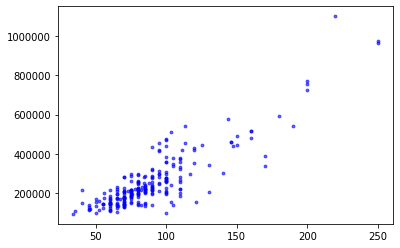

In [508]:
feet = (house_train[:, 2]).tolist()
price = house_train[:, 12].tolist()
plt.scatter(feet, price, alpha=0.6, color='b', s=8)  
plt.show(price, price)

## 2 get OLS model

In [406]:
X = house_train[:, 0:12]
Y = house_train[:, 12]
Y = np.reshape(Y, (Y.shape[0], 1))
Betas = OLS(X, Y)
Y_pre = Predict(X, Betas)

## 3 model evaluation

### R^2

In [162]:
R2 = R_suqare(Y_pre, Y)
print(R2)

0.829640480582757


### Ftest

In [193]:
F_value, P_value =  Ftest(Betas, Y_pre, Y, N=250, K=11)
print(round(F_value, 2), round(P_value, 20))

105.37 2.2204e-16


### Ttest and confidence interval

In [221]:
N = 250
U = Y - Y_pre
R2 = R_suqare(Y_pre, Y)
print(R2, np.sum((Y-Y_pre)**2)**0.5)
col_names = house_price.columns[0:12]
res_data, res_df = T_test(Betas, X, Y, Y_pre, N, col_names)
res_df

0.829640480582757 929943.1378056643


,beta,t-value,Pr(>|t|),low_bound,up_boud,in
Ones,-20324.927720,-1.364074,1.738330e-01,-49678.260846,9028.405406,1.0
City Zone,-8545.351212,-5.794101,2.165552e-08,-11450.779179,-5639.923246,1.0
m^2,3303.535538,17.151911,0.000000e+00,2924.104638,3682.966437,1.0
Rooms,-9401.335439,-1.728309,8.522988e-02,-20117.379073,1314.708196,1.0
Bathrooms,30244.383089,3.218326,1.468780e-03,11731.208728,48757.557451,1.0
Elevator,4753.826983,0.591136,5.549902e-01,-11088.615416,20596.269381,1.0
"""Atico""",17709.052227,1.237177,2.172408e-01,-10489.696392,45907.800846,1.0
Terrasse,2603.893600,0.250269,8.025949e-01,-17892.702485,23100.489684,1.0
Parking,74776.518143,3.975703,9.310860e-05,37724.018927,111829.017359,1.0
Kitchen,-3600.796539,-0.330011,7.416820e-01,-25095.746076,17894.152998,1.0


In [436]:
N = 250
Betas1 = ridge_reg(X, Y, 2.0)
Y_pre1 = Predict(X, Betas1)
R2 = R_suqare(Y_pre1, Y)
print(R2, np.sum((Y-Y_pre1)**2)**0.5)
res_data1, res_df1 = T_test(Betas1, X, Y, Y_pre1, N, col_names)
res_df1

0.8291538743237377 931270.3118831174


,beta,t-value,Pr(>|t|),low_bound,up_boud,in
Ones,-18958.893981,-1.270581,2.051183e-01,-48354.118897,10436.330935,1.0
City Zone,-8748.957774,-5.923700,1.095134e-08,-11658.532240,-5839.383308,1.0
m^2,3341.380331,17.323677,0.000000e+00,2961.407924,3721.352738,1.0
Rooms,-9679.342006,-1.776881,7.686515e-02,-20410.679109,1051.995096,1.0
Bathrooms,28418.873545,3.019763,2.805416e-03,9879.277992,46958.469097,1.0
Elevator,4935.635678,0.612869,5.405480e-01,-10929.416359,20800.687716,1.0
"""Atico""",15164.851448,1.057926,2.911619e-01,-13074.141189,43403.844084,1.0
Terrasse,2493.677707,0.239335,8.110521e-01,-18032.170220,23019.525635,1.0
Parking,64849.559781,3.442995,6.795837e-04,27744.180863,101954.938700,1.0
Kitchen,-2463.527607,-0.225459,8.218156e-01,-23989.153793,19062.098580,1.0


## feature select

In [356]:
ls1 = np.where(res_data[:, 2]>=0.1)
ls1 = ls1[0].tolist()
ls2 = np.where(res_data[:, 2]<0.1)
ls2 = ls2[0].tolist()

In [361]:
ls2 = [0, 1, 2]
ls1 = [3, 4, 5, 6, 7, 8, 9, 10, 11]

In [328]:
l = ls2 + [ls1[0], ls1[2]]
l.sort()
l

[0, 1, 2, 3, 4, 6, 8, 10]

In [434]:
N = 250
ls1

R2s, RES = [], []
for i  in range(len(ls1)+1):
    feat_idxs = ls2 + ls1[0:i]
    feat_idxs.sort()
    print(feat_idxs)
    X_new = X[:, feat_idxs]
    RES1 = 0
    R2s1 = 0
    for j in range(10):
        test_idxs = [i+25*j for i in range(25)]
        train_idxs = list(set(all_idxs)-set(test_idxs))
        X_tran, Y_train = X_new[train_idxs, :], Y[train_idxs,:]
        X_test, Y_test = X_new[test_idxs, :], Y[test_idxs,:]
        Betas1 = ridge_reg(X_tran, Y_train, alpha_i)
        Y_pre1 = Predict(X_test, Betas1)
        R2 = R_suqare(Y_pre1, Y_test)
        res = np.sum((Y_test-Y_pre1)**2)**0.5
        RES1 += res
        R2s1 += R2
    R2s.append(R2s1/5.0)
    RES.append(RES1/5.0)

[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [353]:
[0, 1, 2, 4, 8, 10]

9

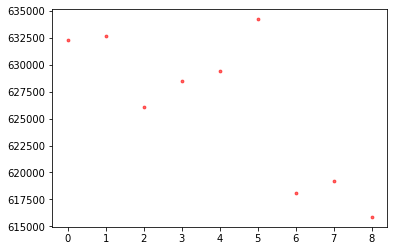

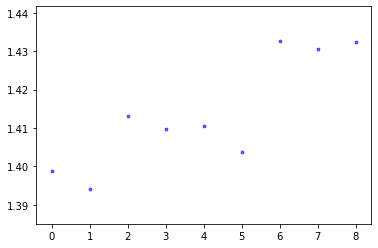

In [363]:
#RES_new = np.array(RES) - 444000
x_a = [i for i in range(len(ls1))]
plt.scatter(x_a, RES, alpha=0.6, color='r', s=8)  
plt.show()
plt.scatter(x_a, R2s, alpha=0.6, color='b', s=8)  
plt.show()

## lambda select

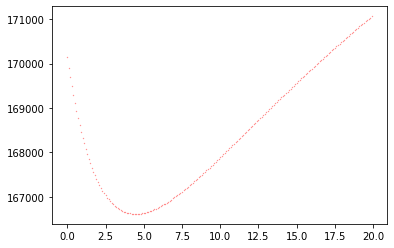

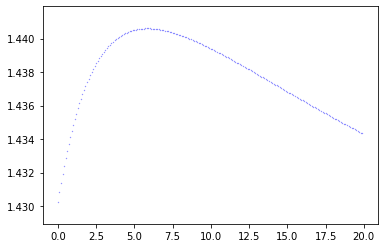

In [359]:
N = 250
j = 0
all_idxs = [i for i in range(250)]
alphas = [i*0.1 for i in range(200)]
RES = []
R2s = []
for alpha_i in alphas:
    RES1 = 0
    R2s1 = 0
    for j in range(10):
        test_idxs = [i+25*j for i in range(25)]
        train_idxs = list(set(all_idxs)-set(test_idxs))
        X_tran, Y_train = X[train_idxs, :], Y[train_idxs,:]
        X_test, Y_test = X[test_idxs, :], Y[test_idxs,:]
        Betas1 = ridge_reg(X_tran, Y_train, alpha_i)
        Y_pre1 = Predict(X_test, Betas1)
        R2 = R_suqare(Y_pre1, Y_test)
        res = np.sum((Y_test-Y_pre1)**2)**0.5
        RES1 += res
        R2s1 += R2
    R2s.append(R2s1/5.0)
    RES.append(RES1/5.0)
import matplotlib.pyplot as plt
RES_new = np.array(RES) - 444000
plt.scatter(alphas, RES_new, alpha=0.6, color='r', s=0.1)  
plt.show()
plt.scatter(alphas, R2s, alpha=0.6, color='b', s=0.1)  
plt.show()

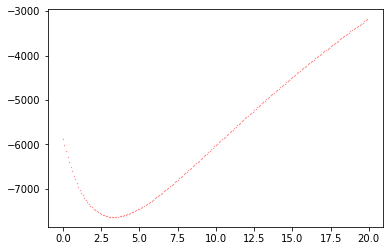

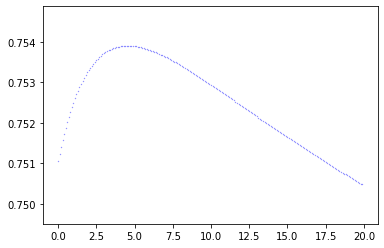

optimal lambda is 3.3000000000000003


In [418]:
N = 250
j = 0
x_idxs = [0, 1, 2, 3, 4, 5, 8, 10]
all_idxs = [i for i in range(250)]
alphas = [i*0.1 for i in range(200)]
RES = []
R2s = []
for alpha_i in alphas:
    RES1 = 0
    R2s1 = 0
    X_new = X[:, x_idxs]
    for j in range(5):
        test_idxs = [i+50*j for i in range(50)]
        train_idxs = list(set(all_idxs)-set(test_idxs))
        X_tran, Y_train = X_new[train_idxs, :], Y[train_idxs,:]
        X_test, Y_test = X_new[test_idxs, :], Y[test_idxs,:]
        Betas1 = ridge_reg(X_tran, Y_train, alpha_i)
        Y_pre1 = Predict(X_test, Betas1)
        R2 = R_suqare(Y_pre1, Y_test)
        res = np.sum((Y_test-Y_pre1)**2)**0.5
        RES1 += res
        R2s1 += R2
    R2s.append(R2s1/5.0)
    RES.append(RES1/5.0)
import matplotlib.pyplot as plt
RES_new = np.array(RES) - 444000
plt.scatter(alphas, RES_new, alpha=0.6, color='r', s=0.1)  
plt.show()
plt.scatter(alphas, R2s, alpha=0.6, color='b', s=0.1)  
plt.show()
print('optimal lambda is {}'.format(alphas[RES.index(min(RES))]))

In [435]:
x_idxs = [0, 1, 2,3, 4, 5,6,7, 9,10,11]
def run_select(x_idxs, house_train, times=10):
    best_lams = []
    data = deepcopy(house_train)
    for i in range(times):
        N = 250
        j = 0
        RES = []
        R2s = []
        all_idxs = [i for i in range(250)]
        alphas = [i*0.1 for i in range(200)]
        np.random.shuffle(data)
        XX = data[:, 0:12]
        Y = data[:, 12]
        Y = np.reshape(Y, (Y.shape[0], 1))
        for alpha_i in alphas:
            RES1 = 0
            R2s1 = 0
            X_new = XX[:, x_idxs]
            for j in range(5):
                test_idxs = [i+50*j for i in range(50)]
                train_idxs = list(set(all_idxs)-set(test_idxs))
                X_tran, Y_train = X_new[train_idxs, :], Y[train_idxs,:]
                X_test, Y_test = X_new[test_idxs, :], Y[test_idxs,:]
                Betas1 = ridge_reg(X_tran, Y_train, alpha_i)
                Y_pre1 = Predict(X_test, Betas1)
                R2 = R_suqare(Y_pre1, Y_test)
                res = np.sum((Y_test-Y_pre1)**2)**0.5
                RES1 += res
                R2s1 += R2
            R2s.append(R2s1/5.0)
            RES.append(RES1/5.0)
        import matplotlib.pyplot as plt
        RES_new = np.array(RES) - 444000
        plt.scatter(alphas, RES_new, alpha=0.6, color='r', s=0.1)  
        plt.show()
        plt.scatter(alphas, R2s, alpha=0.6, color='b', s=0.1)  
        plt.show()
        optimal_val = alphas[RES.index(min(RES))]
        best_lams.append(optimal_val)
        print('optimal lambda is {}'.format(alphas[RES.index(min(RES))]))
    return best_lams

In [432]:
np.mean(np.array(best_lams))
np.var(np.array(best_lams))

21.423100000000005

### 3.1 adjustment for final model

In [446]:
len(col_names)

12

In [510]:
lam= 0.5
x_idxs = [0, 1, 2,3,4, 5,6,7,9,10,11]
X_new = X
X_train, Y_train = X_new[:, x_idxs], Y
Betasf = ridge_reg(X_train, Y_train, lam=lam)
Y_pre_f = Predict(X_train, Betasf)
R2 = R_suqare(Y_pre_f, Y_train)
res = np.sum((Y_train-Y_pre_f)**2)**0.5
R2 = R_suqare(Y_pre_f, Y_train)
print(R2, np.sum((Y_train-Y_pre_f)**2)**0.5)
col_names = house_price.columns[0:11]
col_names.delete(8)
res_data, res_df = T_test(Betasf, X_train, Y_train, Y_pre_f, N, col_names)
res_df

IndexError: too many indices for array

In [455]:
lam= 1.0
x_idxs = [0, 1, 2,3,4, 5,6,7,9,10,11]
X_new = X
X_train, Y_train = X_new[:, x_idxs], Y
Betasf = ridge_reg(X_train, Y_train, lam=lam)
Y_pre_f = Predict(X_train, Betasf)
R2 = R_suqare(Y_pre_f, Y_train)
res = np.sum((Y_train-Y_pre_f)**2)**0.5
R2 = R_suqare(Y_pre_f, Y_train)
print(R2, np.sum((Y_train-Y_pre_f)**2)**0.5)
col_names = house_price.columns[0:11]
col_names.delete(8)
res_data, res_df = T_test(Betasf, X_train, Y_train, Y_pre_f, N, col_names)
res_df

0.8181864995521282 960696.6030879413


,beta,t-value,Pr(>|t|),low_bound,up_boud,in
Ones,-25493.935978,-1.666528,9.691832e-02,-55630.281878,4642.409923,1.0
City Zone,-8960.059684,-5.889528,1.306036e-08,-11957.127748,-5962.991619,1.0
m^2,3556.699207,18.924090,0.000000e+00,3186.446404,3926.952011,1.0
Rooms,-13197.506590,-2.387944,1.772060e-02,-24085.150906,-2309.862274,1.0
Bathrooms,29139.760043,3.001563,2.970832e-03,10014.615005,48264.905082,1.0
Elevator,6369.257064,0.767597,4.434841e-01,-9977.119850,22715.633979,1.0
"""Atico""",9062.486309,0.619243,5.363461e-01,-19768.034299,37893.006917,1.0
Terrasse,6072.207066,0.567713,5.707626e-01,-14998.725414,27143.139545,1.0
Parking,1200.472317,0.107137,9.147702e-01,-20873.431427,23274.376062,1.0
Kitchen,-50114.106175,-2.408647,1.676960e-02,-91101.763848,-9126.448501,1.0


In [509]:
Betasf

array([[-25493.93597757],
       [ -8960.05968365],
       [  3556.69920739],
       [-13197.50659037],
       [ 29139.76004345],
       [  6369.25706424],
       [  9062.48630885],
       [  6072.20706558],
       [  1200.47231736],
       [-50114.10617469],
       [ 54690.81912016]])

## 4 prediction

In [ ]:
lam= 1.90
x_idxs = [0, 1, 2,3 ,4, 5,6,7 ,9,10,11]

In [15]:
house_price_test = pd.read_csv('./data_problemset1/Housing_Prices_predict.csv')
house_price_test["City Zone"] = pd.factorize(house_price_test["City Zone"])[0].astype(np.uint16)
col_name = house_price_test.columns.tolist()
col_name.insert(col_name.index("City Zone"),"Ones")
house_price_test = house_price_test.reindex(columns=col_name)
house_price_test["Ones"] = pd.Series(np.ones(200).tolist())
house_test = house_price_test.to_numpy()

In [452]:
price_test = Predict(house_test[:, x_idxs], Betasf) 
price_test = np.array(np.reshape(price_test, (200,))).tolist()

In [464]:
col_name

['City Zone',
 'Ones',
 'City Zone Code',
 'm^2',
 'Rooms',
 'Bathrooms',
 'Elevator',
 '"Atico"',
 'Terrasse',
 'Parking',
 'Kitchen',
 'House Style',
 'Yard',
 'Predicted Price',
 'Unnamed: 12',
 'R2 in the sample',
 'Your equation']

In [466]:
house_price_res = pd.read_csv('./data_problemset1/Housing_Prices_predict.csv')
col_name = house_price_res.columns.tolist()
col_name.insert(col_name.index("m^2"), "Ones")
col_name.insert(col_name.index("m^2"), "City Zone Code")
house_price_res = house_price_res.reindex(columns=col_name)
house_price_res['Ones'] = house_price_test["Ones"]
house_price_res['City Zone Code'] = house_price_test["City Zone"]
house_price_res["Predicted Price"] =  pd.Series(price_test)
house_price_res['R2 in the sample'] = 0.81819
house_price_res.to_excel("./data_problemset1/pre_res1.xlsx")

In [480]:
house_price_test.columns

Index(['Ones', 'City Zone', 'm^2', 'Rooms', 'Bathrooms', 'Elevator', '"Atico"',
       'Terrasse', 'Parking', 'Kitchen', 'House Style', 'Yard',
       'Predicted Price', 'Unnamed: 12', 'R2 in the sample', 'Your equation'],
      dtype='object')

In [491]:
line0 = ''
j = 0
for i in x_idxs:
    name = house_price_res.columns.tolist()[1:13][i]
    beta_i = round(Betasf[j][0], 4)
    if beta_i < 0:
        plus = ''
    else:
        plus = '+'
    linei = '{}{}*{}'.format(plus, beta_i, name )
    print(linei)
    j +=1
line0

-25493.936*Ones
-8960.0597*City Zone Code
+3556.6992*m^2
-13197.5066*Rooms
+29139.76*Bathrooms
+6369.2571*Elevator
+9062.4863*"Atico"
+6072.2071*Terrasse
+1200.4723*Kitchen
-50114.1062*House Style
+54690.8191*Yard


''